# SentiMeal Infering

This notebook contains code for infering predictions from a model (trained on YELP dataset) on restaurants from Graz

In [ ]:
%%capture
!pip install datasets transformers huggingface_hub

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import re

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

sns.set_theme(style="whitegrid")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/IUI/new8010.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/IUI/new8020.xlsx')
print(df1.shape, df2.shape)
df = pd.concat([df1, df2])
df = df.replace(to_replace='None', value=np.nan).dropna(subset=["text", "review_stars"]).reset_index(drop=True)
print(df.shape)
df.head()

(27541, 15) (13841, 15)
(41370, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Benoit Hex,4.0,We had a nice dinner in this great fish restau...,09/05/2022 20:31:37
1,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Wendy,5.0,Good vibes. Fresh and deliciously cooked fish....,11/10/2018 20:47:22
2,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Evgenii Kuznetcov,1.0,Worst experience ever. I had booked a table by...,12/07/2022 17:36:14
3,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Roeland L.C. Heijting,5.0,Very nice choice of fish. The menu is small bu...,06/27/2018 02:55:53
4,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Melody Zemann,5.0,I always visit here when I visit Graz.\nFish s...,06/12/2022 20:57:51


In [ ]:
def filter_text(text):
  result = re.search(r"(\(Translated by Google\))([\s\S]*)(\(Original)\)", text)
  text_new = ""
  try:
    text_new = result.group(2).strip()
  except:
    text_new = text
  return text_new

df["text"] = df["text"].apply(filter_text)

In [ ]:
review_list = []

for i, row in df.iterrows():
  stars = row["review_stars"]
  if stars < 3: sentiment = 0
  elif stars > 3: sentiment = 2
  else: sentiment = 1

  df.loc[i, "sentiment"] = sentiment
  review_list.append({"review_stars": row["review_stars"], "text": row["text"], "date": row["date"], "sentiment": sentiment})

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

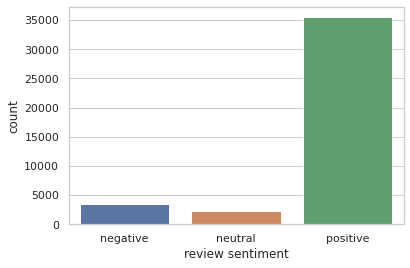

In [ ]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [ ]:
labels = df["sentiment"].to_list()
reviews = df["text"].to_list()

Load model and infer

In [ ]:
from transformers import DistilBertForSequenceClassification
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/IUI/model_15k")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
sigmoid = nn.Sigmoid()
def get_prob(test_encoding):
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].to("cpu").numpy())
  sigmoid_vector = sigmoid(outputs.logits).to("cpu").numpy()[0]
  return y, sigmoid_vector[0], sigmoid_vector[2]

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
y_pred = []
prob_neg_list = []
prob_pos_list = []
for i in df["text"]:
  test_encoding = tokenizer(i, truncation=True, padding=True)
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  y, prob_neg, prob_pos = get_prob(test_encoding)
  y_pred.append(y)
  prob_neg_list.append(prob_neg)
  prob_pos_list.append(prob_pos)

In [ ]:
df["prob_neg"] = prob_neg_list
df["prob_pos"] = prob_pos_list

              precision    recall  f1-score   support

    negative       0.77      0.77      0.77      3550
     neutral       0.22      0.73      0.33      2341
    positive       0.99      0.84      0.91     35479

    accuracy                           0.82     41370
   macro avg       0.66      0.78      0.67     41370
weighted avg       0.93      0.82      0.86     41370

[[ 2742   771    37]
 [  373  1705   263]
 [  431  5405 29643]]


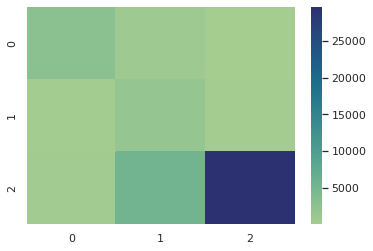

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

y_true = df["sentiment"].to_list()

target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), cmap="crest")

In [ ]:
df.to_csv("graz_reviews_restaurants_test.csv", index=False)